##Speaker_recognition_with_wav2vec2

In [ ]:
!pip install datasets>=1.18.3
!pip install transformers==4.17.0
!pip install librosa
!pip install seaborn
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.6 MB/s eta 0:00:00


# Dataset

In [ ]:
from datasets import load_dataset, load_metric, Audio, Dataset
from tqdm.auto import tqdm

import os
import numpy as np
import pandas as pd
import torchaudio

os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# this is my kaggle .json you can upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khsulemani","key":"18955b5dbcea35546f1e6a1760b5e9ce"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# this cell is important to execute as the toy dataset in your drive

Mounted at /content/drive


In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Jan 11 03:38 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
!kaggle datasets list

ref                                                          title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hummaamqaasim/jobs-in-data                                   Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           3651         72  1.0              
thedrcat/daigt-v2-train-dataset                              DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           3770        299  1.0              
vishakhdapat/price-of-used-toyota-corolla-cars               Price of Used Toyota Corolla Cars            30KB  2024-01-08 06:06:37            917         22  0.9411765        
sazidthe1/world-population-data                              World Population Data                        14KB  202

In [ ]:
!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech
!unzip darpa-timit-acousticphonetic-continuous-speech.zip
!unzip data.zip
!pip install webrtcvad

Streaming output truncated to the last 5000 lines.
  inflating: data/TRAIN/DR6/MTXS0/SI1060.WRD  
  inflating: data/TRAIN/DR6/MTXS0/SI1690.PHN  
  inflating: data/TRAIN/DR6/MTXS0/SI1690.TXT  
  inflating: data/TRAIN/DR6/MTXS0/SI1690.WAV  
  inflating: data/TRAIN/DR6/MTXS0/SI1690.WAV.wav  
  inflating: data/TRAIN/DR6/MTXS0/SI1690.WRD  
  inflating: data/TRAIN/DR6/MTXS0/SI2320.PHN  
  inflating: data/TRAIN/DR6/MTXS0/SI2320.TXT  
  inflating: data/TRAIN/DR6/MTXS0/SI2320.WAV  
  inflating: data/TRAIN/DR6/MTXS0/SI2320.WAV.wav  
  inflating: data/TRAIN/DR6/MTXS0/SI2320.WRD  
  inflating: data/TRAIN/DR6/MTXS0/SX160.PHN  
  inflating: data/TRAIN/DR6/MTXS0/SX160.TXT  
  inflating: data/TRAIN/DR6/MTXS0/SX160.WAV  
  inflating: data/TRAIN/DR6/MTXS0/SX160.WAV.wav  
  inflating: data/TRAIN/DR6/MTXS0/SX160.WRD  
  inflating: data/TRAIN/DR6/MTXS0/SX250.PHN  
  inflating: data/TRAIN/DR6/MTXS0/SX250.TXT  
  inflating: data/TRAIN/DR6/MTXS0/SX250.WAV  
  inflating: data/TRAIN/DR6/MTXS0/SX250.WAV.wav  
  

##  Load TIMIT Dataset

In [ ]:
data_path = '/content/data/'

In [ ]:
df_train = pd.read_csv(os.path.join( '/content/train_data.csv'))
df_test = pd.read_csv(os.path.join( '/content/test_data.csv'))
df = pd.concat([df_train, df_test])
df = df[df['is_converted_audio'] == False]

In [ ]:
df

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
5,6.0,TRAIN,DR4,MMDM0,SI681.TXT,TRAIN/DR4/MMDM0/SI681.TXT,TRAIN\\DR4\\MMDM0\\SI681.TXT,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,8395.0,TEST,DR8,MPAM0,SX19.WAV,TEST/DR8/MPAM0/SX19.WAV,TEST\\DR8\\MPAM0\\SX19.WAV,False,True,False,False,False
8395,8396.0,TEST,DR8,MPAM0,SX109.TXT,TEST/DR8/MPAM0/SX109.TXT,TEST\\DR8\\MPAM0\\SX109.TXT,False,False,False,False,True
8397,8398.0,TEST,DR8,MPAM0,SX289.WRD,TEST/DR8/MPAM0/SX289.WRD,TEST\\DR8\\MPAM0\\SX289.WRD,False,False,True,False,False
8398,8399.0,TEST,DR8,MPAM0,SX109.WAV,TEST/DR8/MPAM0/SX109.WAV,TEST\\DR8\\MPAM0\\SX109.WAV,False,True,False,False,False


## Split Dataset

### Merge Entries
One entry in the dataframe represents one file. Audio, word, and phonetics are stored separately in different files. Then, we would need to combine them.

In [ ]:
data = {}

for idx, row in tqdm(df.iterrows()):
    path = row['path_from_data_dir']
    entry_id = path.split('.')[0]

    if entry_id not in data:
        data[entry_id] = {}

    if row['is_audio'] is True:
        data[entry_id]['audio_file'] = os.path.join(data_path, path)
    elif row['is_word_file'] is True:
        data[entry_id]['word_file'] = os.path.join(data_path, path)
    elif row['is_phonetic_file'] is True:
        data[entry_id]['phonetic_file'] = os.path.join(data_path, path)

0it [00:00, ?it/s]

### Random Split
We split the data randomly into 80/10/10.

In [ ]:
import random

keys = [key for key in data.keys() if len(data[key]) == 3]
random.Random(101).shuffle(keys)

num_train = int(len(keys) * 0.8)
num_valid = int(len(keys) * 0.1)
num_test = len(keys) - num_train - num_valid

train_keys = keys[:num_train]
valid_keys = keys[num_train:num_train + num_valid]
test_keys = keys[-num_test:]

In [ ]:
train = { key:data[key] for key in train_keys }
valid = { key:data[key] for key in valid_keys }
test  = { key:data[key] for key in test_keys }

### How many hours are in each set?
At least this helps us understand how big/small our dataset is.

In [ ]:
import librosa

def get_durations(dict_data):
    total_durations = 0

    for entry in dict_data.values():
        audio_data, _ = librosa.load(entry['audio_file'], sr=16_000)
        duration = len(audio_data) / 16_000
        total_durations += duration

    return int(total_durations)

### Save the Split into Files
This is for consistency. Different train/test set could yield different performance.
Hence, we just save them so that later we don't need to redo the split.

In [ ]:
import json

with open("/content/custom_train.json", "w") as f:
    json.dump(train, f)
with open("/content/custom_valid.json", "w") as f:
    json.dump(valid, f)
with open("/content/custom_test.json", "w") as f:
    json.dump(test, f)

# Preprocessing

## Process into HuggingFace Dataset Format

This function, named `convert_to_feature_dict`, takes a dictionary (`data_dict`) as input, which presumably contains information about audio, word, and phonetic files for different entries. The function then extracts the file paths for audio, word, and phonetic files from the input dictionary and organizes them into separate arrays. The function returns a new dictionary with keys ('audio_file', 'word_file', 'phonetic_file') and corresponding values being lists of file paths for audio, word, and phonetic files, respectively. The purpose seems to be converting the original structure of data into a more organized format, where each type of file path is grouped together. This format may be convenient for further processing or analysis, such as feeding the paths into feature extraction methods or organizing data for model training.

In [ ]:
def convert_to_feature_dict(data_dict):
    # convert each feature into an array instead
    audio_files = []
    word_files = []
    phonetic_files = []
    for key, value in data_dict.items():
        audio_files.append(value['audio_file'])
        word_files.append(value['word_file'])
        phonetic_files.append(value['phonetic_file'])

    return {
        'audio_file': audio_files,
        'word_file': word_files,
        'phonetic_file': phonetic_files
    }

In [ ]:
train = convert_to_feature_dict(train)
valid = convert_to_feature_dict(valid)
test  = convert_to_feature_dict(test)

 The specific implementation details depend on the library being used, and there are multiple libraries that include a Dataset class (e.g., PyTorch, TensorFlow, Hugging Face's datasets).

Assuming it is using a library like Hugging Face's datasets, the code would likely be converting the dictionaries into dataset objects, which are structured and optimized for machine learning tasks. This is a common step when working with machine learning frameworks. The resulting train_dataset, valid_dataset, and test_dataset variables can then be used for training, validation, and testing purposes, respectively.

In [ ]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

In [ ]:
print(train_dataset)

Dataset({
    features: ['audio_file', 'word_file', 'phonetic_file'],
    num_rows: 2688
})


## Read files for phonetics

These functions are designed to read and process text data from files, particularly word and phonetic files. The prepare_text_data function is likely intended to be applied to each item in a dataset to enrich the dataset with the extracted text information. This preprocessing step may be relevant for tasks involving natural language processing or speech processing where the content of word and phonetic files is essential for analysis or modeling.

In [ ]:
def read_text_file(filepath):
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)

def prepare_text_data(item):
    item['text'] = read_text_file(item['word_file'])
    item['phonetic'] = read_text_file(item['phonetic_file'])
    return item

The provided code modifies the `train_dataset`, `valid_dataset`, and `test_dataset` by applying the `prepare_text_data` function to each item within them. This function enriches each item with 'text' and 'phonetic' keys, containing processed text data extracted from associated word and phonetic files. Subsequently, unnecessary columns, namely 'word_file' and 'phonetic_file', are removed from the datasets. These transformations aim to enhance the datasets with relevant text information while discarding redundant file path columns, possibly streamlining the datasets for downstream natural language processing or speech-related tasks.

In [ ]:
train_dataset = (train_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
valid_dataset = (valid_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
test_dataset  = (test_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))

Map:   0%|          | 0/2688 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

## Normalize the Phonetics

As we can see the result below, there are *61* phones. However, we don't need to use all of them. "tcl", for example, is just a pause where there is a "t". So, let's keep it up and simplify them a bit.

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
print("num of train phones:\t", len(set(train_phonetics)))

num of train phones:	 61


In [ ]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#'
}

def convert_phon61_to_phon39(sentence):
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)

def normalize_phones(item):
    item['phonetic'] = convert_phon61_to_phon39(item['phonetic'])
    return item

In [ ]:
train_dataset = train_dataset.map(normalize_phones)
valid_dataset = valid_dataset.map(normalize_phones)
test_dataset = test_dataset.map(normalize_phones)

Map:   0%|          | 0/2688 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 39
num of valid phones:	 39
num of test phones:	 39


## Phonetic Distribution
Let's check the distribution of each phone across all three test set. Note that we don't do simple counting. Instead, for each phoneme, we show the ratio of that phoneme relative to that specific set. On test set, obviously, the count of each phoneme is less than the train, but the ratio should be similar to the training set.

In [ ]:
phone_vocabs = set(train_phonetics)
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs]

In [ ]:
train_phone_counts = count_frequency(train_phonetics)
valid_phone_counts = count_frequency(valid_phonetics)
test_phone_counts  = count_frequency(test_phonetics)

In [ ]:
train_phone_ratio = [count / sum(train_phone_counts) for count in train_phone_counts]
valid_phone_ratio = [count / sum(valid_phone_counts) for count in valid_phone_counts]
test_phone_ratio  = [count / sum(test_phone_counts) for count in test_phone_counts]

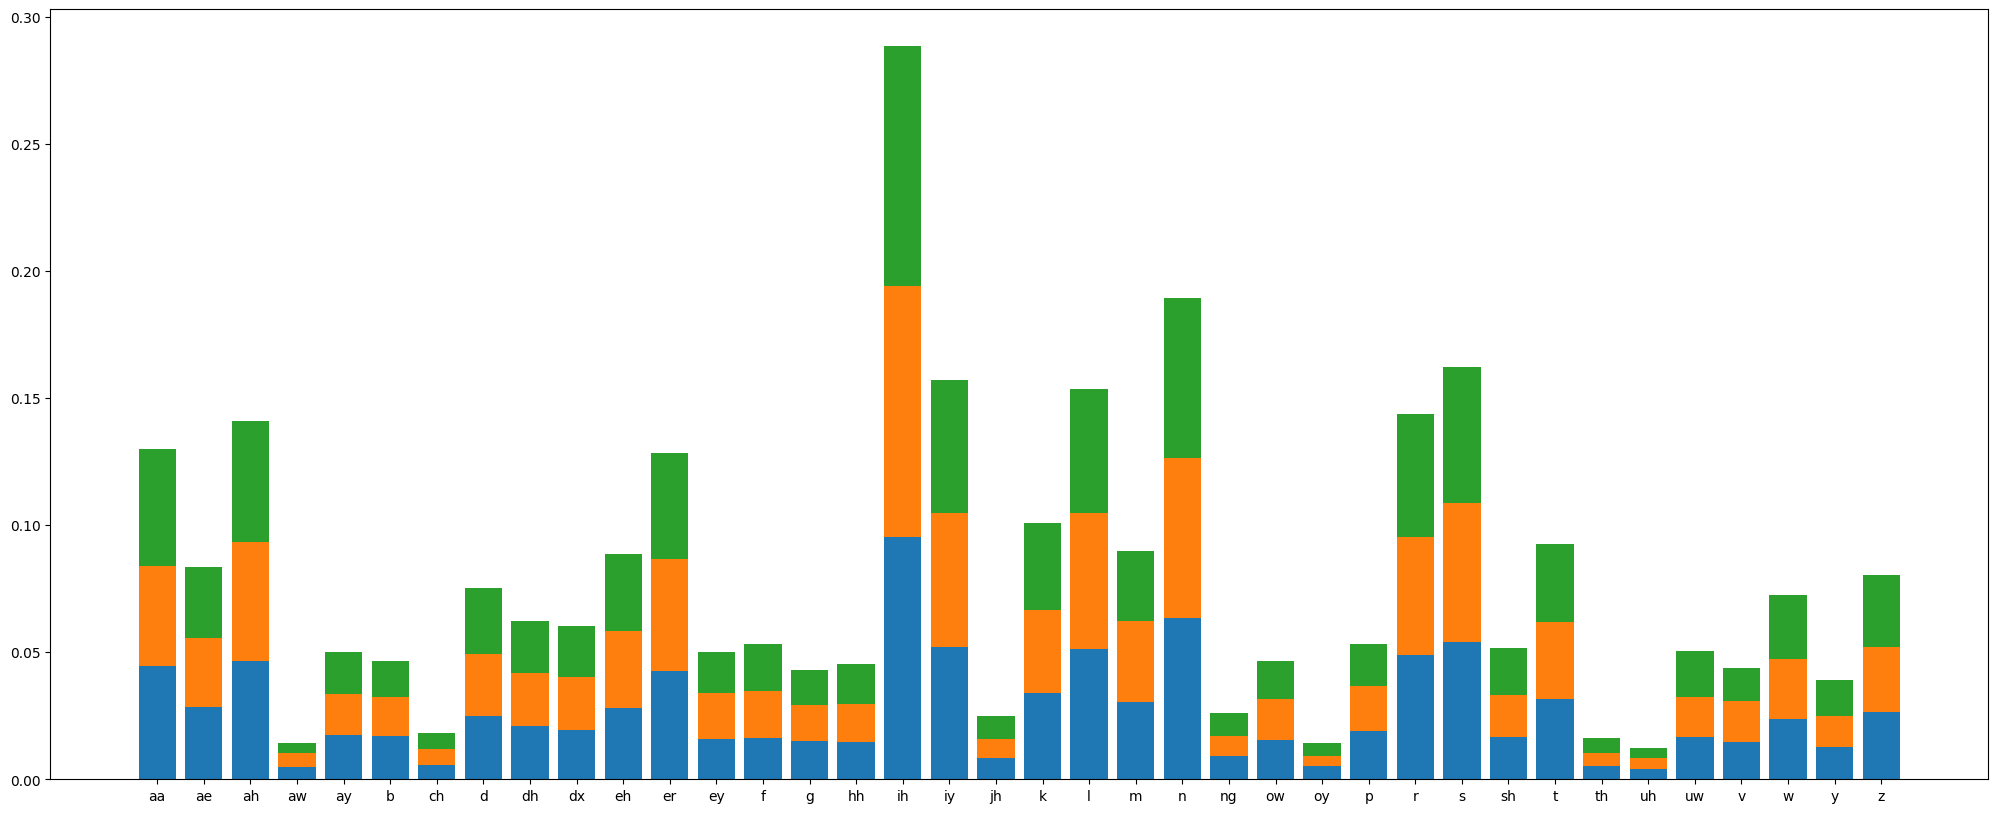

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phone_ratio)
plt.bar(phone_vocabs, valid_phone_ratio, bottom=train_phone_ratio)
plt.bar(phone_vocabs, test_phone_ratio, bottom=[(x+y) for x,y in zip(train_phone_ratio, valid_phone_ratio)])

plt.show()

## Load Audio File
These lines of code transform the `train_dataset`, `valid_dataset`, and `test_dataset` by converting the 'audio_file' column into an 'audio' column with audio-specific data types, using a sampling rate of 16,000 Hz. Additionally, the 'audio_file' column is renamed to 'audio' for consistency. This preprocessing step ensures that the datasets are properly configured for audio-related tasks, facilitating the utilization of audio data in subsequent machine learning models or analyses.

In [ ]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [ ]:
train_dataset[0]

{'audio': {'path': '/content/data/TEST/DR7/FISB0/SA1.WAV',
  'array': array([-6.10351562e-05,  6.10351562e-05,  1.22070312e-04, ...,
          9.15527344e-05,  3.66210938e-04, -3.05175781e-04]),
  'sampling_rate': 16000},
 'text': 'she had your dark suit in greasy wash water all year',
 'phonetic': 'h# sh iy hh ae h# d y er h# d aa r h# k s uw h# ih n h# g r iy z iy w aa sh h# w aa dx er h# aa l y ih er h#'}

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_dataset)-1)

print("Text:", train_dataset[rand_int]["text"])
print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: most precincts had a third of the votes counted
Phonetics: h# m ow s h# p r iy s ih ng h# s hh eh dx ih th er h# d ih v dh ih v ow h# s h# k aw n ih h# d h#
Input array shape: (43520,)
Sampling rate: 16000


## Build Character Set

In [ ]:
vocab_train = list(set(train_phonetics)) + [' ']
vocab_valid = list(set(valid_phonetics)) + [' ']
vocab_test  = list(set(test_phonetics)) + [' ']

In [ ]:
vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


Vocabulary dictionary (vocab_dict) associated with phonetic symbols by replacing the space symbol (' ') with '|', which is intended to enhance clarity. Additionally, it introduces two special tokens, '[UNK]' for unknown symbols and '[PAD]' for padding, into the vocabulary. The adjustments aim to make the space symbol more intuitive, improve the handling of unknown symbols, and facilitate padding in sequence-based tasks, such as phonetic recognition or natural language processing. These modifications contribute to a more interpretable and standardized representation of phonetic symbols, facilitating their use in subsequent machine learning models or analyses.

In [ ]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

42

In [ ]:
# save vocab.json
import json
with open('/content/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

## IPA Symbol
We won't use these symbols in this notebook. This is just for reference, in case you need them.

In [ ]:
symbols = {"a": "ə", "ey": "eɪ", "aa": "ɑ", "ae": "æ", "ah": "ə", "ao": "ɔ",
           "aw": "aʊ", "ay": "aɪ", "ch": "ʧ", "dh": "ð", "eh": "ɛ", "er": "ər",
           "hh": "h", "ih": "ɪ", "jh": "ʤ", "ng": "ŋ",  "ow": "oʊ", "oy": "ɔɪ",
           "sh": "ʃ", "th": "θ", "uh": "ʊ", "uw": "u", "zh": "ʒ", "iy": "i", "y": "j"}

# Modeling

## Input Processor

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

##Wav2Vec2, a popular model for speech processing tasks

In [ ]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from tokenizers.processors import TemplateProcessing

In [ ]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("/content/", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", )  # './' load vocab.json in the current directory
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# This does not prepare the input for the Transformer model.
# This will resample the data and convert the sentence into indices
# Batch here is just for one entry (row)
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["phonetic"]).input_ids
    return batch

In [ ]:
# train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names)
# valid_dataset = valid_dataset.map(prepare_dataset, remove_columns=valid_dataset.column_names)
# test_dataset = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names)
train_dataset = train_dataset.map(prepare_dataset)
valid_dataset = valid_dataset.map(prepare_dataset)
test_dataset = test_dataset.map(prepare_dataset)

Map:   0%|          | 0/2688 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

## Evaluation Metrics

We use WER (Word Error Rate) and CER (Character Error Rate) to measure the performance of our model. After the training, we realize that WER may not be the right fit. CER fits better.

Note that CER here has some errors in our use case because each ARPAbet token is represented by one to three characters. For example, a label token is "ch" and another is "ae", that's two character error right there.

After the training, we will re-evaluate on test-set one more time, which we will evaluate at token level.

The `compute_metrics` function is designed to evaluate the performance of a model in a speech-related task, specifically for automatic speech recognition (ASR). It takes the predictions made by the model, computes the predicted token IDs, and decodes them into strings using a tokenizer. Simultaneously, it decodes the ground truth label token IDs into strings, considering individual tokens. The function then replaces padding tokens in the ground truth labels and computes both the Word Error Rate (WER) and Character Error Rate (CER) using the predictions and ground truth references. The resulting metrics are returned as a dictionary, providing valuable insights into the accuracy of the model's transcriptions compared to the actual phonetic transcriptions of the spoken audio.

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids)
    label_str = tokenizer.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {
        "wer": wer,
        "cer": cer
    }

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-69-daacbc7f35fd>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.1,
    layerdrop=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.75,
    mask_time_length=10,
    mask_feature_prob=0.25,
    mask_feature_length=64,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.bias', 'project_q.bias', 'project_hid.weight', 'project_q.weight', 'quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

In [ ]:
model.freeze_feature_encoder()

## Training

These settings provide a comprehensive configuration for training a Wav2Vec2 model for ASR, including batch size, learning rate, checkpointing, and evaluation strategy. The specific values may be adjusted based on the task requirements and available resources.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='/content/',
    group_by_length=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    fp16=False,
    max_steps=10000,
    save_steps=1000,  #100,
    eval_steps=1000,
    logging_steps=100,
    learning_rate=3e-5,
    warmup_steps=2000,
    save_total_limit=3,
    load_best_model_at_end=True
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


The Trainer instance is now set up to manage the training process, including model updates, logging, and evaluation based on the provided configurations. Training can be initiated by calling trainer.train().

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor.feature_extractor
)

max_steps is given, it will override any value given in num_train_epochs
Using amp half precision backend


In [ ]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

## Evaluate on Test Set

These metrics provide a comprehensive overview of the model's performance on the test dataset, helping to assess its accuracy and effectiveness in transcribing spoken audio.

In [ ]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length, text, audio, phonetic. If input_length, text, audio, phonetic are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 336
  Batch size = 8


{'eval_loss': 0.24967938661575317,
 'eval_wer': 0.6886178861788618,
 'eval_cer': 0.08775885872066268,
 'eval_runtime': 22.5711,
 'eval_samples_per_second': 14.886,
 'eval_steps_per_second': 1.861}

In [ ]:
trainer.evaluate(train_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length, text, audio, phonetic. If input_length, text, audio, phonetic are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2688
  Batch size = 8


{'eval_loss': 0.15721972286701202,
 'eval_wer': 0.5706763872012961,
 'eval_cer': 0.06548152746166402,
 'eval_runtime': 183.5182,
 'eval_samples_per_second': 14.647,
 'eval_steps_per_second': 1.831}

## Save Model

In [ ]:
# save locally
trainer.save_model()